# NY Fed Financial Conditions

## Packages

In [25]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

## Read Data

In [2]:
df = pd.read_parquet(
    path = "financial_conditions_prep.parquet",
    engine = "pyarrow")

## EDA Plotting

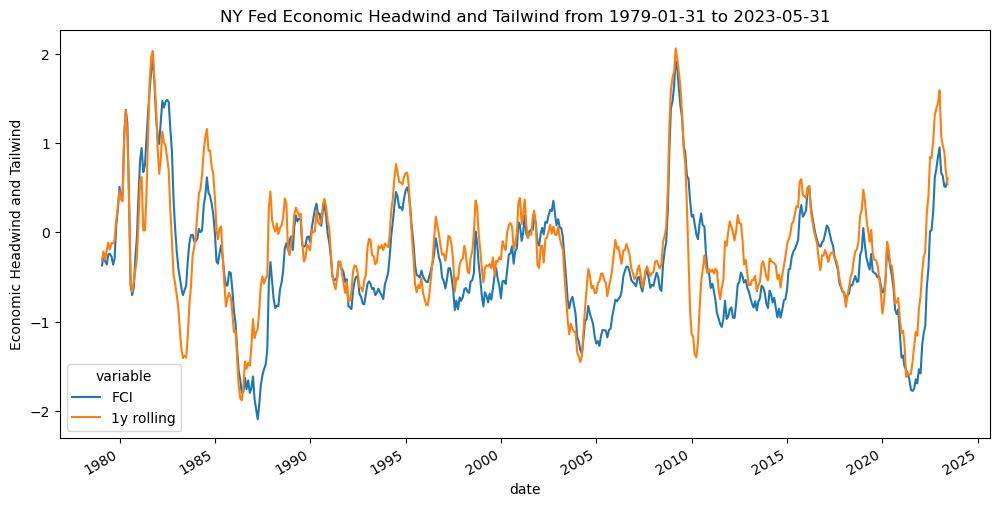

In [13]:
(df.set_index(
    "date").
    rename(columns = {
        "fci_baseline": "FCI",
        "fci_rolling_year": "1y rolling"}).
    plot(
        figsize = (12, 6),
        ylabel = "Economic Headwind and Tailwind",
        title = "NY Fed Economic Headwind and Tailwind from {} to {}".format(
            df.date.min().date(), df.date.max().date())))

plt.show()

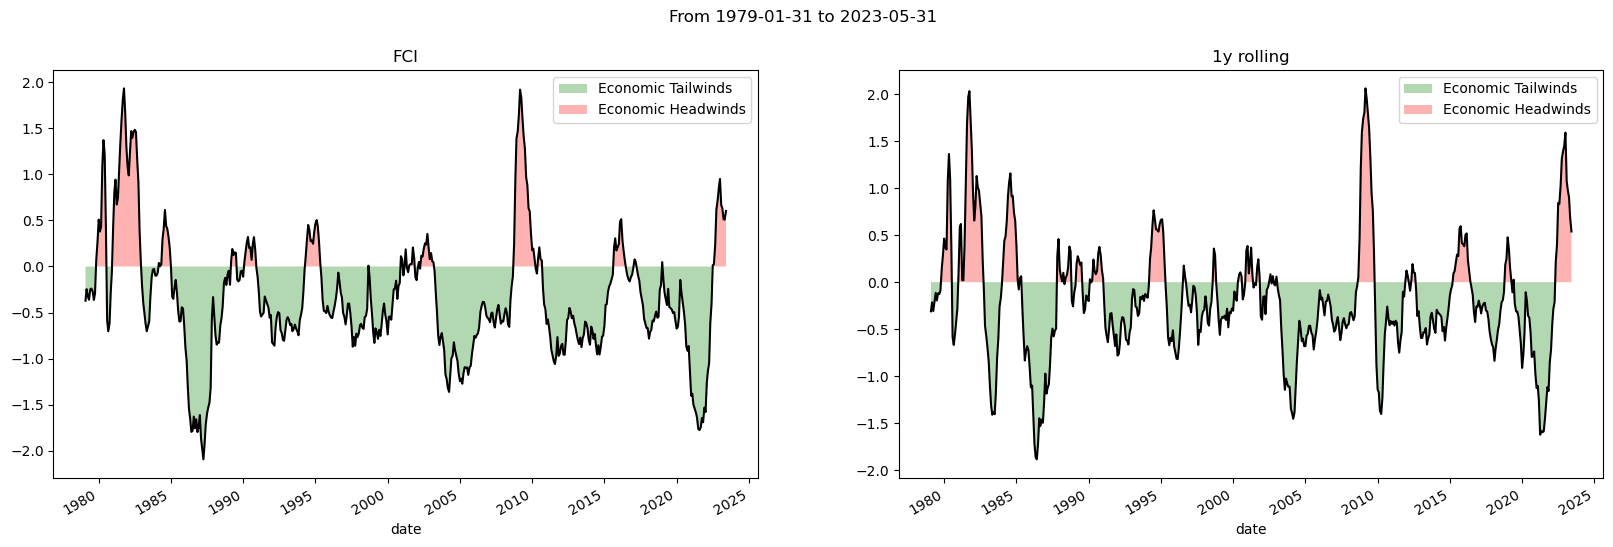

In [28]:
fig, axes = plt.subplots(ncols = 2, figsize = (20, 6))

(df.set_index(
    "date").
    rename(columns = {
        "fci_baseline": "FCI"})
    [["FCI"]].
    plot(
        ax = axes[0],
        color = "black",
        legend = False,
        title = "FCI"))

(df.set_index(
    "date").
    rename(columns = {
        "fci_rolling_year": "1y rolling"})
    [["1y rolling"]].
    plot(
        ax = axes[1],
        color = "black",
        title = "1y rolling",
        legend = False))

axes[0].fill_between(
    x = df.date,
    y1 = df["fci_baseline"].values,
    y2 = 0,
    where = df["fci_baseline"].values > 0,
    facecolor = "red",
    alpha = 0.3)

axes[0].fill_between(
    x = df.date,
    y1 = df["fci_baseline"].values,
    y2 = 0,
    where = df["fci_baseline"].values < 0,
    facecolor = "green",
    alpha = 0.3)

axes[1].fill_between(
    x = df.date,
    y1 = df["fci_rolling_year"].values,
    y2 = 0,
    where = df["fci_rolling_year"].values > 0,
    facecolor = "red",
    alpha = 0.3)

axes[1].fill_between(
    x = df.date,
    y1 = df["fci_rolling_year"].values,
    y2 = 0,
    where = df["fci_rolling_year"].values < 0,
    facecolor = "green",
    alpha = 0.3)

legend_elements = [
    Patch(facecolor = "green", alpha = 0.3, label = "Economic Tailwinds"),
    Patch(facecolor = "red", alpha = 0.3, label = "Economic Headwinds")]

axes[0].legend(handles = legend_elements)
axes[1].legend(handles = legend_elements)

fig.suptitle("From {} to {}".format(
    df.date.min().date(),
    df.date.max().date()))

plt.show()